In [7]:
import numpy as np
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
def load_image(image_path, target_size=None):
    try:
        img_pil = Image.open(image_path).convert('L') 
        if target_size:
            img_pil = img_pil.resize(target_size, Image.Resampling.LANCZOS)
        return np.array(img_pil, dtype=np.float64)
    except FileNotFoundError:
        print(f"Error: '{image_path}' not found. Creating a dummy image.")
        dummy_img = np.zeros((64, 64), dtype=np.float64)
        dummy_img[16:48, 16:48] = 128 
        dummy_img[24:40, 24:40] = 200 
        return dummy_img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None


def add_salt_and_pepper_noise(image, salt_vs_pepper_ratio=0.5, amount=0.04):
    """Adds salt-and-pepper noise to an image."""
    noisy_image = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_vs_pepper_ratio).astype(int)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_vs_pepper_ratio)).astype(int)

    # Add Salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255

    # Add Pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image


image_path = 'oooo.webp' 
TARGET_SIZE = (128, 128)

original_image = load_image(image_path, target_size=TARGET_SIZE)
print(original_image.shape)


(128, 128)


In [8]:
def calculate_energy(current_image, noisy_image, alpha=1.0,beta=0.5):
    
    fidelity_term = np.sum(np.abs(current_image - noisy_image))
    regularization_term = 0.0

    regularization_term += np.sum(np.abs(current_image[:, 1:] - current_image[:, :-1]))
    regularization_term += np.sum(np.abs(current_image[1:, :] - current_image[:-1, :]))
    
    # alpha mare -> ramane cat mai fidel imaginii originale sa nu pierdem din detalii (daca e prea mare riscam sa ramanem cu noise )
    # beta mare -> asigura continuitate cu vecinii ( blur. daca e prea mare, pierdem prea multe detalii )
    total_energy = alpha * fidelity_term + beta * regularization_term

    # 
    return total_energy

def generate_neighbor(current_image, neighborhood_size=1):
    new_image = np.copy(current_image)
    rows, cols = new_image.shape
    r, c = np.random.randint(0, rows), np.random.randint(0, cols)

    r_min = max(0, r - neighborhood_size)
    r_max = min(rows, r + neighborhood_size + 1)
    c_min = max(0, c - neighborhood_size)
    c_max = min(cols, c + neighborhood_size + 1)

    neighbors = new_image[r_min:r_max, c_min:c_max].flatten()

    median_val = np.median(neighbors)
    new_image[r, c] = median_val
    new_image = np.clip(new_image, 0, 255)

    return new_image



In [9]:
import random
def simulated_annealing_denoise(noisy_image,
                                initial_temperature=10000.0,
                                cooling_rate=0.995,
                                min_temperature=1.0,
                                num_iterations_at_temp=5000,
                                alpha=1, beta=0.5):
    """
    Aplică algoritmul Simulated Annealing pentru denoising-ul unei imagini.

    Parametri:
    - noisy_image (np.array): Imaginea de intrare cu zgomot.
    - initial_temperature (float): Temperatura inițială.
    - cooling_rate (float): Rata de răcire (ex: 0.995).
    - min_temperature (float): Temperatura minimă la care se oprește algoritmul.
    - num_iterations_at_temp (int): Numărul de iterații la fiecare nivel de temperatură.
    - alpha (float): Ponderea termenului de fidelitate a datelor în funcția de energie.
    - beta (float): Ponderea termenului de regularizare în funcția de energie.
    """

    current_image = np.copy(noisy_image)
    current_energy = calculate_energy(current_image, noisy_image, alpha, beta)
    best_image = np.copy(current_image)
    best_energy = current_energy
    energy_history = [current_energy]

    temperature = initial_temperature
    iteration_count = 0

    print(f"Start Simulated Annealing. Initial Energy: {current_energy:.2f}")

    while temperature > min_temperature:
        for _ in range(num_iterations_at_temp):
            iteration_count += 1

            new_image = generate_neighbor(current_image,1)

            new_energy = calculate_energy(new_image, noisy_image, alpha, beta)

            # acceptam starea mai buna
            if new_energy < current_energy:
                current_image = new_image
                current_energy = new_energy
            else:
          
                delta_e = new_energy - current_energy
                acceptance_probability = np.exp(-delta_e / temperature)
                if random.random() < acceptance_probability:
                    current_image = new_image
                    current_energy = new_energy

           
            if current_energy < best_energy:
                best_image = np.copy(current_image)
                best_energy = current_energy

            energy_history.append(current_energy)

       
        temperature *= cooling_rate
        print(f"Iteration {iteration_count // num_iterations_at_temp}: Temp={temperature:.2f}, Current Energy={current_energy:.2f}, Best Energy={best_energy:.2f}")

    print(f"\nSimulated Annealing Finished. Final Best Energy: {best_energy:.2f}")
    return best_image, energy_history




Starting Simulated Annealing...
Start Simulated Annealing. Initial Energy: 2369932.00
Iteration 1: Temp=45000.00, Current Energy=2296691.50, Best Energy=2296688.50
Iteration 2: Temp=40500.00, Current Energy=2209091.88, Best Energy=2209091.88
Iteration 3: Temp=36450.00, Current Energy=2139184.62, Best Energy=2139184.62
Iteration 4: Temp=32805.00, Current Energy=2080008.12, Best Energy=2079999.12
Iteration 5: Temp=29524.50, Current Energy=2016486.50, Best Energy=2016486.50
Iteration 6: Temp=26572.05, Current Energy=1962185.12, Best Energy=1962185.12
Iteration 7: Temp=23914.85, Current Energy=1910073.69, Best Energy=1910073.69
Iteration 8: Temp=21523.36, Current Energy=1863576.50, Best Energy=1863576.50
Iteration 9: Temp=19371.02, Current Energy=1804037.47, Best Energy=1804037.47
Iteration 10: Temp=17433.92, Current Energy=1753726.97, Best Energy=1753726.97
Iteration 11: Temp=15690.53, Current Energy=1716453.50, Best Energy=1716453.50
Iteration 12: Temp=14121.48, Current Energy=1665643.3

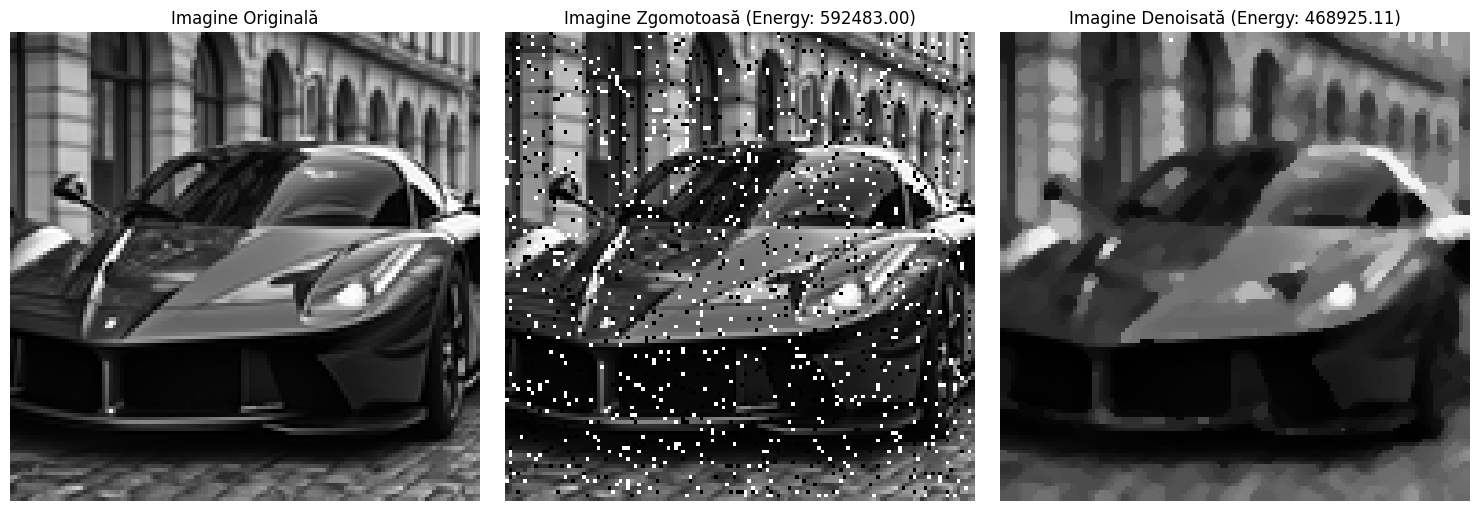

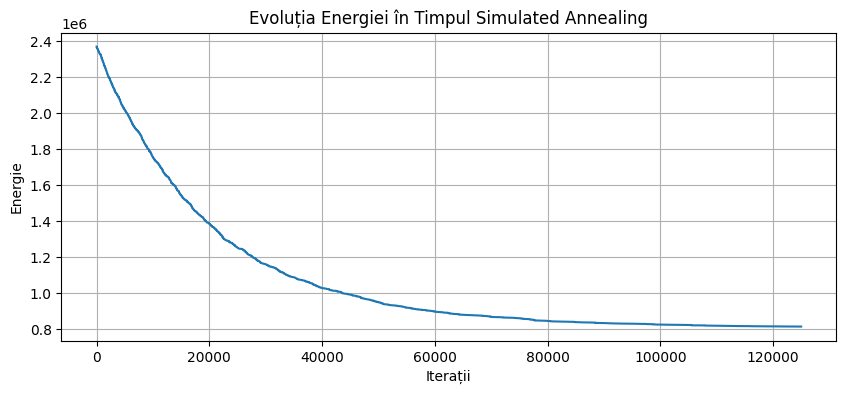

In [10]:
if __name__ == "__main__":
    image_path = 'original23.jpeg' 
    original_image = load_image(image_path, target_size=(128, 128))

    if original_image is not None:
        # Adaugă zgomot "sare și piper"
        noisy_image = add_salt_and_pepper_noise(original_image, amount=0.1) 
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Imagine Originală")
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f"Imagine Zgomotoasă (Energy: {calculate_energy(noisy_image, noisy_image):.2f})")
        plt.imshow(noisy_image, cmap='gray')
        plt.axis('off')

        # Rulează Simulated Annealing
        print("\nStarting Simulated Annealing...")
        denoised_image, energy_evolution = simulated_annealing_denoise(
            noisy_image,
            initial_temperature=50000.0, 
            cooling_rate=0.9,
            min_temperature=0.1,
            num_iterations_at_temp=1000 ,
            alpha=1,
            beta=2
        )

        plt.subplot(1, 3, 3)
        plt.title(f"Imagine Denoisată (Energy: {calculate_energy(denoised_image, noisy_image):.2f})")
        plt.imshow(denoised_image, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Afișează evoluția energiei
        plt.figure(figsize=(10, 4))
        plt.plot(energy_evolution)
        plt.title("Evoluția Energiei în Timpul Simulated Annealing")
        plt.xlabel("Iterații")
        plt.ylabel("Energie")
        plt.grid(True)
        plt.show()

    else:
        print("Nu s-a putut încărca sau crea o imagine pentru testare.")

In [11]:
image = load_image('oooo.webp')
print(image)

[[107.  88.  92. ...  83.  84.  91.]
 [101. 102.  94. ...  54.  70.  64.]
 [107. 101.  93. ...  84.  83.  77.]
 ...
 [ 85.  26.   7. ...   9.  53.  87.]
 [ 91.  48.  38. ...  28.  65.  73.]
 [ 92.  82.  58. ...  86.  56.  76.]]



Starting Tabu Search...
Tabu Search: Start cu energie = 9365200.00
Tabu Search: Iteration 0/10000, Current Energy = 9363514.40, Best Global Energy = 9363514.40
Tabu Search: Iteration 1000/10000, Current Energy = 7786568.20, Best Global Energy = 7786568.20
Tabu Search: Iteration 2000/10000, Current Energy = 6482391.00, Best Global Energy = 6482391.00
Tabu Search: Iteration 3000/10000, Current Energy = 5449470.80, Best Global Energy = 5449470.80
Tabu Search: Iteration 4000/10000, Current Energy = 4543710.45, Best Global Energy = 4543710.45
Tabu Search: Iteration 5000/10000, Current Energy = 3761252.42, Best Global Energy = 3761252.42
Tabu Search: Iteration 6000/10000, Current Energy = 3102835.75, Best Global Energy = 3102835.75
Tabu Search: Iteration 7000/10000, Current Energy = 2603746.65, Best Global Energy = 2603746.65
Tabu Search: Iteration 8000/10000, Current Energy = 2260443.88, Best Global Energy = 2260443.88
Tabu Search: Iteration 9000/10000, Current Energy = 2034948.02, Best Gl

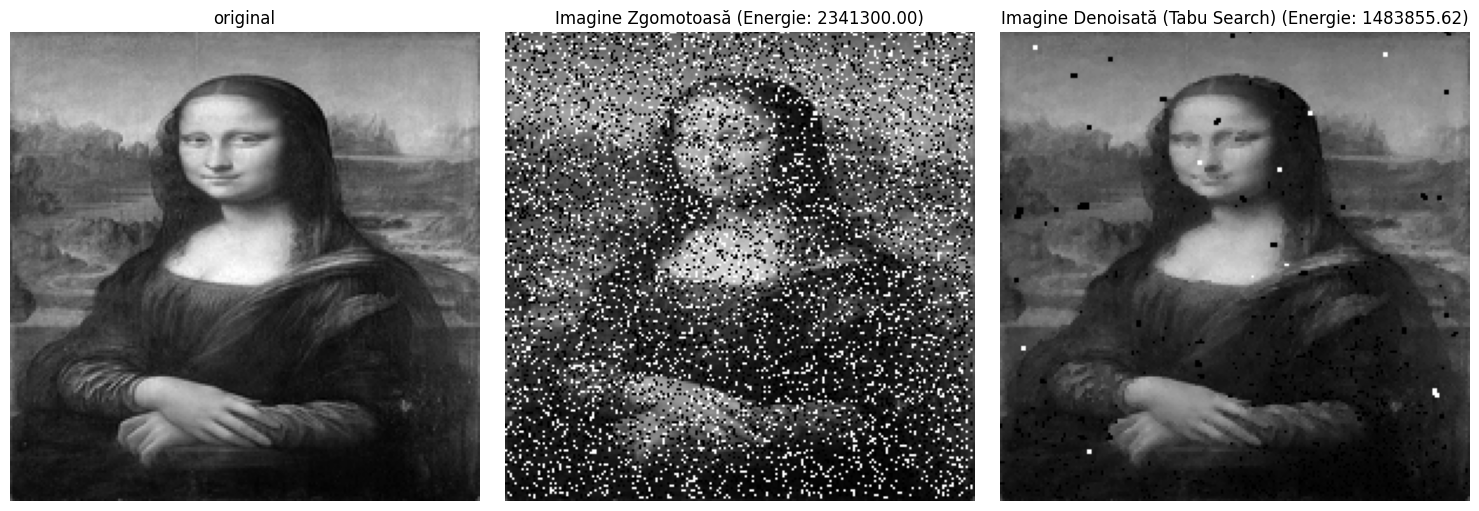

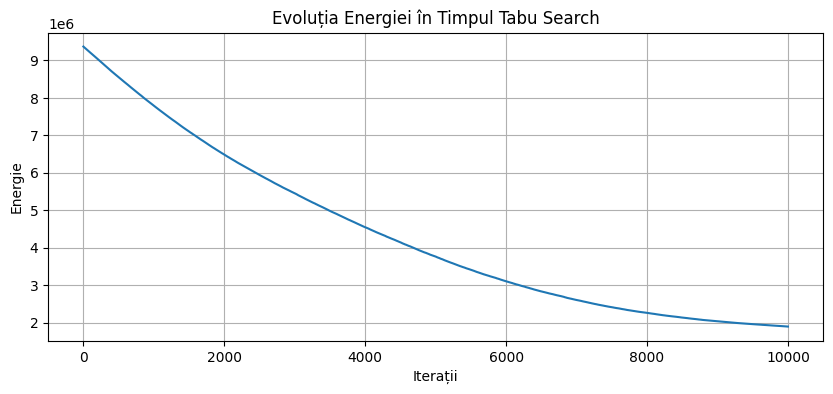

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from collections import deque # Pentru lista tabu eficientă


def generate_neighbor(current_image, neighborhood_size=1):
    new_image = np.copy(current_image)
    rows, cols = new_image.shape
    r, c = np.random.randint(0, rows), np.random.randint(0, cols)

    r_min = max(0, r - neighborhood_size)
    r_max = min(rows, r + neighborhood_size + 1)
    c_min = max(0, c - neighborhood_size)
    c_max = min(cols, c + neighborhood_size + 1)

    neighbors = new_image[r_min:r_max, c_min:c_max].flatten()

    median_val = np.median(neighbors)
    new_image[r, c] = median_val
    new_image = np.clip(new_image, 0, 255)

# return imagine noua si coordonatele pixelului pentru istoric
    return new_image, r, c

#  Tabu Search 

def tabu_search_denoising(noisy_image,
                          max_iterations=1000,
                          tabu_list_size=50,
                          neighborhood_size=1,
                          alpha=1, beta=0.5):
    """
    Implementează algoritmul Tabu Search pentru denoising de imagine.

    Argumente:
        noisy_image (np.ndarray): Imaginea zgomotoasă de denoisat.
        max_iterations (int): Numărul maxim de iterații.
        tabu_list_size (int): Mărimea listei tabu (numărul de mișcări recente de evitat).
        neighborhood_size (int): Mărimea vecinătății pentru generarea noii valori a pixelului.
        alpha (float): Ponderea termenului de fidelitate a datelor în funcția de cost.
        beta (float): Ponderea termenului de netezire în funcția de cost.

    Returnează:
        tuple: (best_global_solution, energy_history)
               - best_global_solution (np.ndarray): Imaginea denoisată optimă găsită.
               - energy_history (list): O listă cu evoluția energiei curente pe parcursul iterațiilor.
    """
    gif_every = 1000
    gif_frames =[]
    current_solution = np.copy(noisy_image)
    current_energy = calculate_energy(current_solution, noisy_image, alpha, beta)

    best_global_solution = np.copy(current_solution)
    best_global_energy = current_energy

    tabu_list = deque(maxlen=tabu_list_size)
    energy_history = [current_energy] 

    print(f"Tabu Search: Start cu energie = {current_energy:.2f}")

    for iteration in range(max_iterations):
        num_neighbors_to_explore = 100 

        best_neighbor_this_iteration = None
        best_neighbor_energy_this_iteration = float('inf')
        best_neighbor_move = None 

        for _ in range(num_neighbors_to_explore):
           
            temp_neighbor_image, r, c = generate_neighbor(current_solution, neighborhood_size)
            move = (r, c) 

            neighbor_energy = calculate_energy(temp_neighbor_image, noisy_image, alpha, beta)

            is_tabu = (move in tabu_list) 

            if (not is_tabu) or (neighbor_energy < best_global_energy):
                if neighbor_energy < best_neighbor_energy_this_iteration:
                    best_neighbor_energy_this_iteration = neighbor_energy
                    best_neighbor_this_iteration = temp_neighbor_image
                    best_neighbor_move = move 

        if best_neighbor_this_iteration is not None: 
            current_solution = best_neighbor_this_iteration
            current_energy = best_neighbor_energy_this_iteration

            if best_neighbor_move is not None: 
                tabu_list.append(best_neighbor_move) 
            
            if current_energy < best_global_energy:
                best_global_energy = current_energy
                best_global_solution = np.copy(current_solution)

        else:

            print(f"Tabu Search: Blocat la iterația {iteration}. Nu s-a găsit un vecin acceptabil.")
            # break 

        energy_history.append(current_energy)
        if iteration % gif_every == 0 or iteration == max_iterations - 1:
                    frame = Image.fromarray(np.uint8(current_solution))
                    gif_frames.append(frame.convert("P"))

        if iteration % (max_iterations // 10) == 0:
            print(f"Tabu Search: Iteration {iteration}/{max_iterations}, Current Energy = {current_energy:.2f}, Best Global Energy = {best_global_energy:.2f}")
    if gif_frames:
            gif_frames[0].save("tabu_search_progress.gif", save_all=True, append_images=gif_frames[1:], duration=300, loop=0)
            print("GIF saved as tabu_search_progress.gif")

    print(f"Tabu Search: Finalizat. Cea mai bună energie globală = {best_global_energy:.2f}")
    return best_global_solution, energy_history



if __name__ == "__main__":
    image_path = 'oooo.webp'
    TARGET_SIZE = (200, 200)

    original_image = load_image(image_path, target_size=TARGET_SIZE)

    if original_image is not None:
        
        noisy_image = add_salt_and_pepper_noise(original_image.astype(np.float64), amount=0.3) 
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("original")
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f"Imagine Zgomotoasă (Energie: {calculate_energy(noisy_image, noisy_image):.2f})")
        plt.imshow(noisy_image, cmap='gray')
        plt.axis('off')

        # --- Rulăm Tabu Search ---
        print("\nStarting Tabu Search...")
        denoised_image_ts, energy_evolution_ts = tabu_search_denoising(
            noisy_image,
            max_iterations=10000,   
            tabu_list_size=100,    
            neighborhood_size=1,  
            alpha=0.7,             
            beta=2             
        )

        plt.subplot(1, 3, 3)
        plt.title(f"Imagine Denoisată (Tabu Search) (Energie: {calculate_energy(denoised_image_ts, noisy_image):.2f})")
        plt.imshow(denoised_image_ts, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

       
        plt.figure(figsize=(10, 4))
        plt.plot(energy_evolution_ts)
        plt.title("Evoluția Energiei în Timpul Tabu Search")
        plt.xlabel("Iterații")
        plt.ylabel("Energie")
        plt.grid(True)
        plt.show()

    else:
        print("Nu s-a putut încărca sau crea o imagine pentru testare.")